In [2]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

In [3]:
train = datasets.MNIST(
    '../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)
test= datasets.MNIST(
    '../data', train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)

100%|██████████| 9912422/9912422 [00:00<00:00, 23764257.59it/s]


Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz to ../data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 9581246.05it/s]


Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 5860597.12it/s]


Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4552097.67it/s]

Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\MNIST\raw



In [4]:
def plot(x):
    img = (np.array(x.detach().cpu(), dtype='float')).reshape(28,28)

    plt.imshow(img, cmap='gray')
    plt.show()

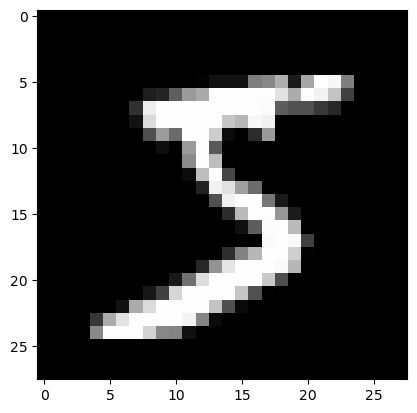

In [5]:
plot(train.data[0])

In [6]:
x= train.data.float() / 255
y= train.targets

In [7]:
x= x.view(x.size(0), -1)
print(x.shape, y.shape)

torch.Size([60000, 784]) torch.Size([60000])


In [8]:
input_size = x.size(-1) #784
output_size = int(max(y)) + 1 # 10

print('input_size: %d, output_size: %d' % (input_size, output_size))

input_size: 784, output_size: 10


In [9]:
# Train / Valid ratio
ratios = [.8,.2]

train_cnt = int(x.size(0) * ratios[0]) # 48000
valid_cnt = int(x.size(0) * ratios[1]) # 12000
test_cnt = len(test.data) # 10000
cnts= [train_cnt, valid_cnt] # cnt[48000, 12000, 10000]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

indices =torch.randperm(x.size(0))

x= torch.index_select(x, dim=0, index=indices)
y= torch.index_select(y, dim=0, index=indices)

x= list(x.split(cnts, dim=0))
y= list(y.split(cnts, dim=0))

x +=[(test.data.float() / 255.).view(test_cnt, -1)]
y +=[test.targets]

for x_i, y_i in zip(x,y):
    print(x_i.size(), y_i.size())

Train 48000 / Valid 12000 / Test 10000 samples.
torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


In [10]:
model = nn.Sequential(
    nn.Linear(input_size, 500),
    nn.LeakyReLU(),
    nn.Linear(500, 400),
    nn.LeakyReLU(),
    nn.Linear(400, 300),
    nn.LeakyReLU(),
    nn.Linear(300, 200),
    nn.LeakyReLU(),
    nn.Linear(200, 100),
    nn.LeakyReLU(),
    nn.Linear(100, 50),
    nn.LeakyReLU(),
    nn.LeakyReLU(),
    nn.Linear(50, output_size),
    nn.LogSoftmax(dim=1),
)

In [11]:
optimizer=optim.Adam(model.parameters())
crit=nn.NLLLoss()

In [13]:
device=torch.device('cpu')
if torch.cuda.is_available():
    device=torch.device('cuda')

In [14]:
model=model.to(device)

x=[x_i.to(device) for x_i in x]
y=[y_i.to(device) for y_i in y]

In [15]:
n_epochs = 1000
batch_size= 256
print_interval = 10

lowest_loss = np.inf
best_model = None

early_stop = 50
lowest_epoch = np.inf

In [16]:
train_history, valid_history = [], []

for i in range(n_epochs):
    indices = torch.randperm(x[0].size(0)).to(device)
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)

    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    train_loss, valid_loss = 0,0
    y_hat = []

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        train_loss += float(loss)

    train_loss = train_loss / len(x_)

    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0

        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i.squeeze())

            valid_loss += float(loss)

            y_hat +=[y_hat_i]

    valid_loss = valid_loss / len(x_)

    train_history += [train_loss]
    valid_history += [valid_loss]

    if (i + 1) % print_interval == 0:
        print('Epoch %d: train loss=%.4e valid_loss=%.4e lowest_loss=%.4e' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))

    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i

        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("Ther is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1,
                                                        lowest_loss))
model.load_state_dict(best_model)

Epoch 10: train loss=2.1870e-02 valid_loss=1.2274e-01 lowest_loss=1.0179e-01
Epoch 20: train loss=1.3274e-02 valid_loss=1.3689e-01 lowest_loss=1.0179e-01
Epoch 30: train loss=5.5632e-03 valid_loss=1.2498e-01 lowest_loss=1.0179e-01
Epoch 40: train loss=3.2926e-03 valid_loss=1.3480e-01 lowest_loss=1.0179e-01
Epoch 50: train loss=5.3454e-03 valid_loss=1.1645e-01 lowest_loss=1.0179e-01
Ther is no improvement during last 50 epochs.
The best validation loss from epoch 9: 1.0179e-01


<All keys matched successfully>

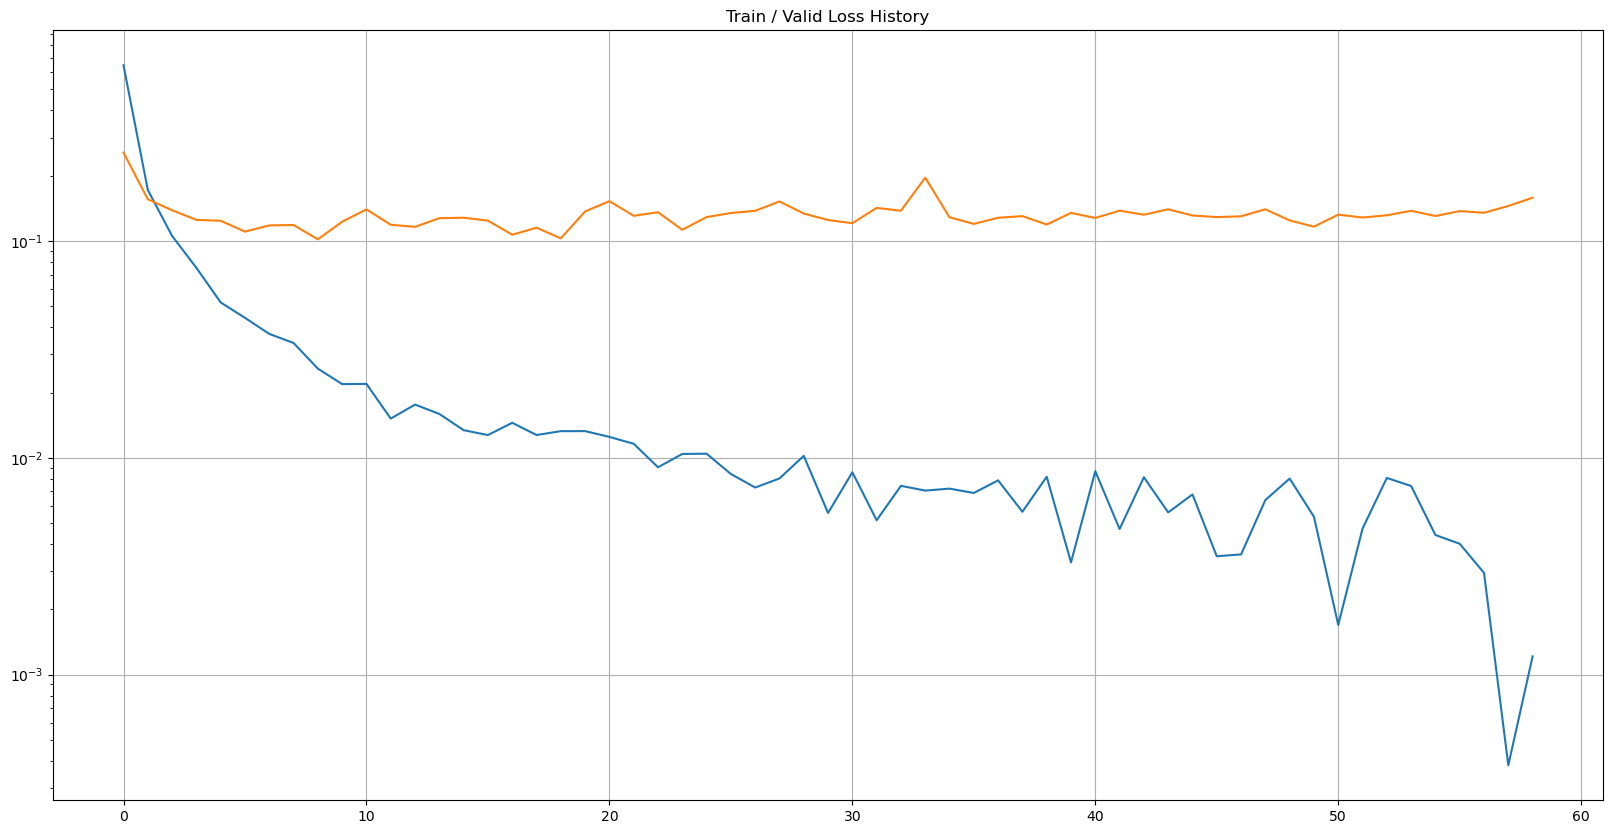

In [17]:
plot_from = 0 

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

In [18]:
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[-1].split(batch_size, dim=0)
    y_ = y[-1].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        test_loss += loss

        y_hat += [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

print("Test loss: %.4e" % test_loss)

Test loss: 9.4091e-02


In [19]:
correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[-1].size(0))

print("Test Accuracy: %.4f" % (correct_cnt / total_cnt))

Test Accuracy: 0.9755


In [20]:
import pandas as pd
from sklearn.metrics import confusion_matrix

In [21]:
pd.DataFrame(confusion_matrix(y[-1], torch.argmax(y_hat, dim=-1)),
             index=['true_%d' % i for i in range(10)],
             columns=['pred_%d' % i for i in range(10)])

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,965,1,2,1,1,1,1,4,1,3
true_1,0,1125,0,2,0,1,1,0,6,0
true_2,2,6,1008,6,1,0,1,3,4,1
true_3,0,0,4,992,0,5,0,0,5,4
true_4,1,0,8,0,949,1,2,2,0,19
true_5,2,0,0,6,0,875,1,0,4,4
true_6,4,5,0,1,11,12,922,0,3,0
true_7,0,4,8,5,1,0,0,994,2,14
true_8,0,0,3,16,2,4,1,3,940,5
true_9,1,2,0,7,6,1,0,3,4,985
